In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from algorithms.astar2k import astar2k
from algorithms.thetastar import thetastar
from util.structures import Map, Node
from util.containers import Open, Closed, OpenAndClosed
from util import functions as uf
from test import movingai_util as mutil
from draw.draw import draw
import random
%matplotlib inline

In [2]:
def simple_test(search_func, task, *args):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    lengths = [36, 30, 30, 21, 28, 24, 32, 27, 42, 23, 35, 37, 23, 26, 40, 36, 42, 28, 44, 36, 38, 29, 33, 42, 44]

    if (task is None) or not (0 <= task < 25):
        task = random.randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    #try:
    if 1 != 2:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
        number_of_steps = result[2]
        nodes_created = result[3]
        if result[0]:
            path = uf.make_path(result[1])
            correct = int(path[1])  == int(length)
            draw(task_map, start, goal, path[0], *result[4:])
            print("Path found! Length: " + str(path[1]) + \
                ". Nodes created: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps) + ". Correct: " + str(correct))
        else:
            draw(task_map, start, goal, [start], *result[4:], *result[5:])
            print("Path not found!")
        return result

    #except Exception as e:
        print("Execution error")
        print(e)


In [11]:
def massive_test(search_function, heuristic_function, task_map, tasks, w=1, EPS=1e-6):
    corrected = 0
    results = np.zeros((3, len(tasks)))
    for i, (start_i, start_j, goal_i, goal_j, exp_len) in tqdm(enumerate(tasks)):
        try:
            result = search_function(task_map, start_i, start_j, goal_i, goal_j, heuristic_function, w)
            nodes_expanded = result[2]
            nodes_opened = result[3]
            if result[0]:
                path = uf.make_path(result[1])
                correct = abs(path[1] - exp_len) < EPS
                if correct:
                    corrected += 1
                d = path[1]
                if (exp_len > 0):
                    d /= exp_len
                results[0, i] = len(nodes_expanded)
                results[1, i] = d
                #print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodes_opened) + len(nodes_expanded)) + ". Number of steps: " + str(len(nodes_expanded)) + ". Correct: " + str(correct))
            #
                #print("Path not found!")
        except Exception as e:
            print("Execution error")
            print(e)

    print(f'Correct: {corrected} of {len(tasks)}')
    return results

In [12]:
def moscow_2_test(heuristic_func):
    map_path = "test/data/Moscow_2_1024.map"
    tasks_path = "test/data/Moscow_2_1024.map.scen"
    task_map = mutil.read_map_from_movingai_file(map_path)
    tasks = mutil.read_tasks_from_movingai_file(tasks_path)
    random.seed(50)
    random.shuffle(tasks)

    df = pd.DataFrame(columns=["4-astar", "32-astar", "theta-star"])
    for i in tqdm(range(5)):
        (s_i, s_j, f_i, f_j, l) = tasks[i]
        start = Node(i = s_i, j = s_j)
        goal = Node(i = f_i, j = f_j)

        result4 = astar2k(task_map, start.i, start.j, goal.i, goal.j, heuristic_func, Open, Closed, k=2)
        result32 = astar2k(task_map, start.i, start.j, goal.i, goal.j, heuristic_func, Open, Closed, k=5)
        resulttheta = thetastar(task_map, start.i, start.j, goal.i, goal.j, heuristic_func, Open, Closed)
        #number_of_steps = result[2]
        #nodes_created = result[3]
        l4 = -1
        l32 = -1
        ltheta = -1
        if result4[0]:
            _, l4 = uf.make_path(result4[1])
        if result32[0]:
            _, l32 = uf.make_path(result32[1])
        if resulttheta[0]:
            _, ltheta = uf.make_path(resulttheta[1])
        df = df.append({"4-astar": l4, "32-astar": l32, "theta-star": ltheta}, ignore_index=True)
    display(df)

In [36]:
moscow_2_test(uf.euclidian_distance)

100%|██████████| 5/5 [02:44<00:00, 32.82s/it]


,4-astar,32-astar,theta-star
0,708.0,609.986486,603.099633
1,1038.0,822.333673,822.879518
2,1851.0,1506.729425,1504.290037
3,1105.0,834.153699,830.628261
4,137.0,98.338150,98.334456


In [ ]:
#%time res = simple_test(astar2k, 0, euclidian_distance, Open, Closed, 5)

In [ ]:
#%time res = simple_test(thetastar, 0, euclidian_distance, YourOpen, YourClosed)

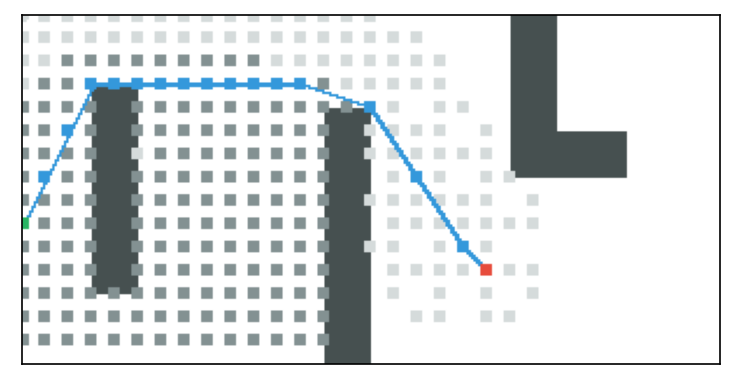

Path found! Length: 27.49579770596882. Nodes created: 3939. Number of steps: 172. Correct: False


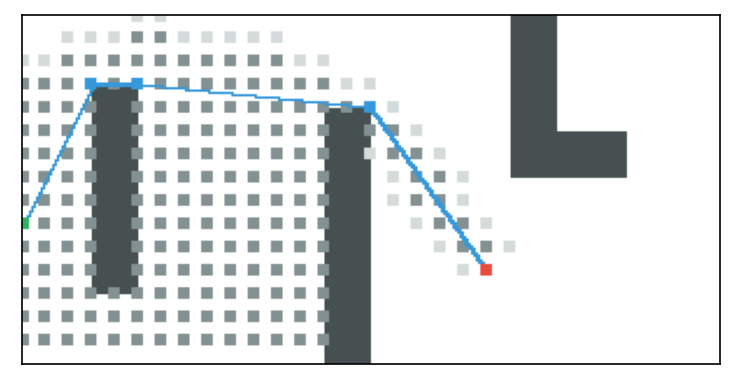

Path found! Length: 27.360404820662886. Nodes created: 688. Number of steps: 187. Correct: False


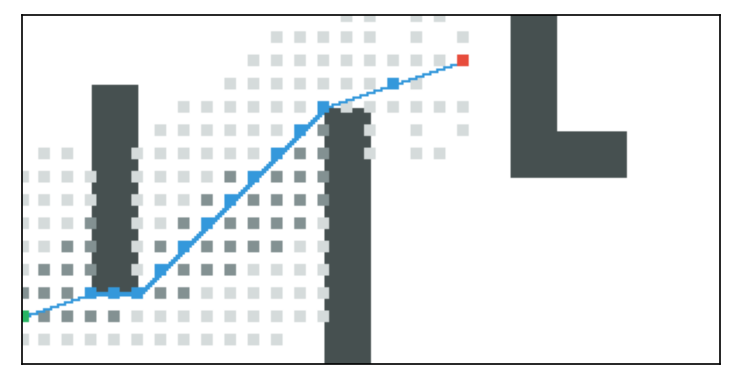

Path found! Length: 22.8005414794899. Nodes created: 1293. Number of steps: 54. Correct: False


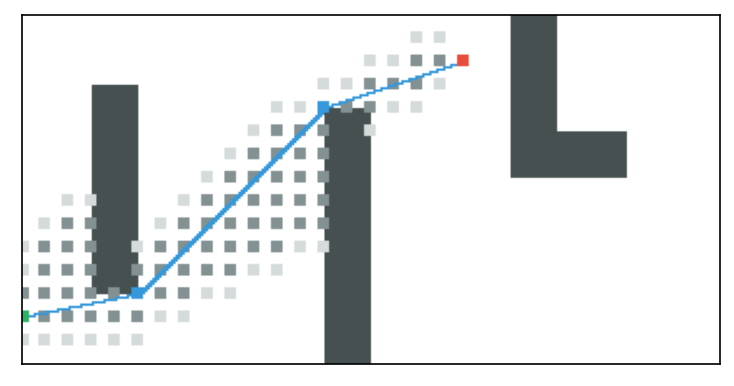

Path found! Length: 22.737283332914306. Nodes created: 251. Number of steps: 67. Correct: False


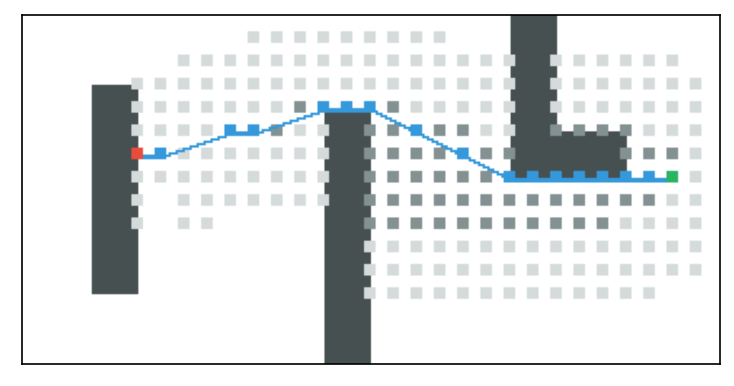

Path found! Length: 24.032759252836126. Nodes created: 1639. Number of steps: 67. Correct: False


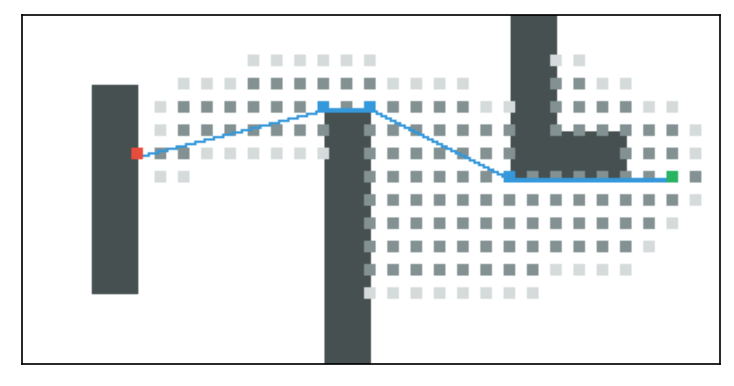

Path found! Length: 23.95441518373469. Nodes created: 453. Number of steps: 120. Correct: False


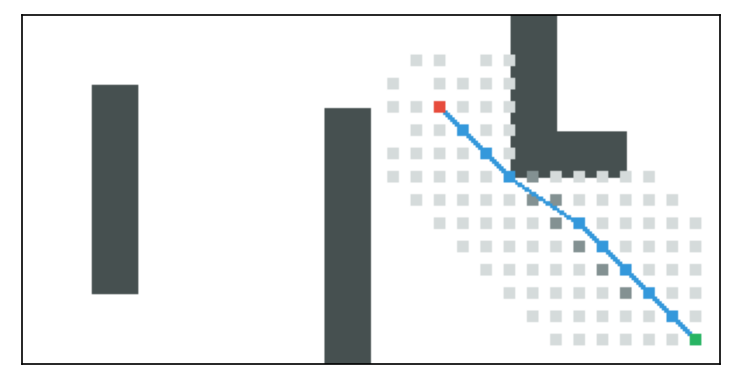

Path found! Length: 14.919259774448753. Nodes created: 407. Number of steps: 17. Correct: False


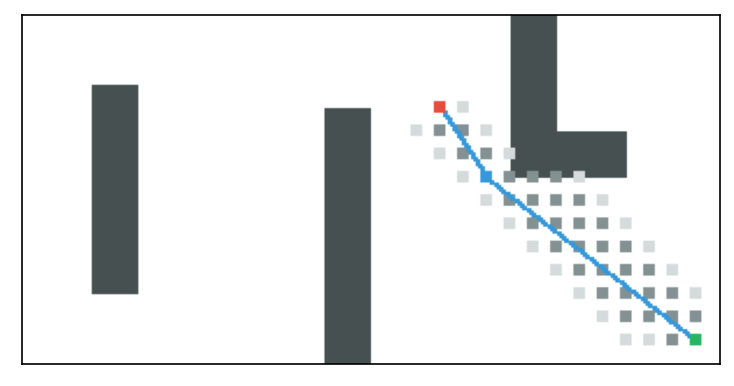

Path found! Length: 15.007305526455369. Nodes created: 130. Number of steps: 35. Correct: False


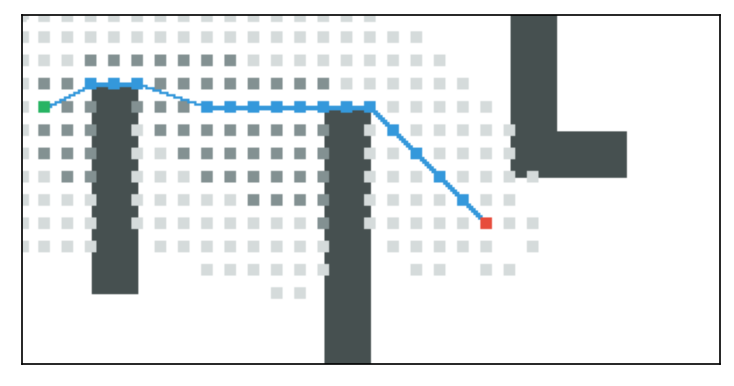

Path found! Length: 21.469413449533647. Nodes created: 1848. Number of steps: 73. Correct: False


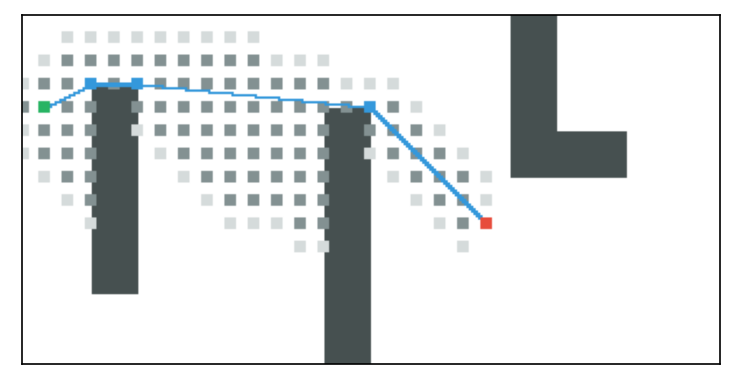

Path found! Length: 21.357011410486155. Nodes created: 333. Number of steps: 88. Correct: False


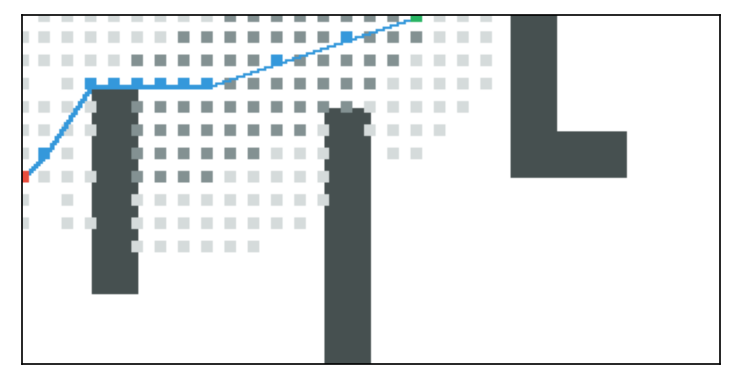

Path found! Length: 19.50659781834222. Nodes created: 1874. Number of steps: 75. Correct: False


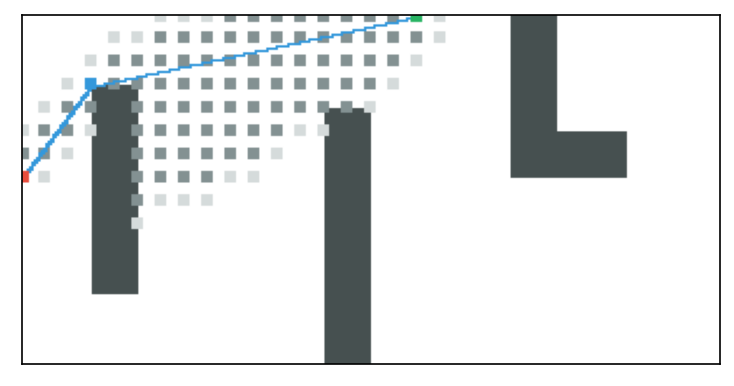

Path found! Length: 19.317821063276355. Nodes created: 306. Number of steps: 82. Correct: False


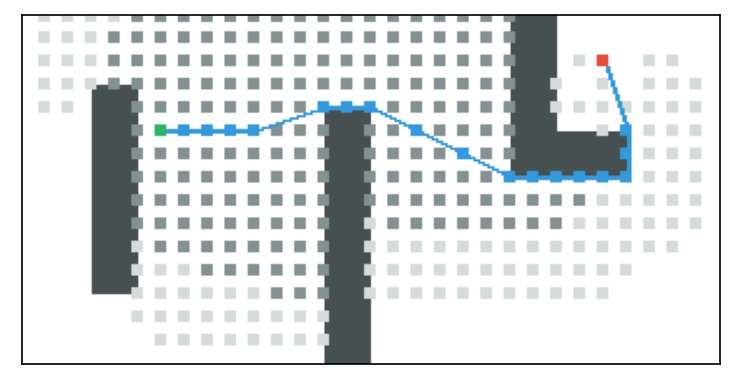

Path found! Length: 26.03275925283613. Nodes created: 4867. Number of steps: 197. Correct: False


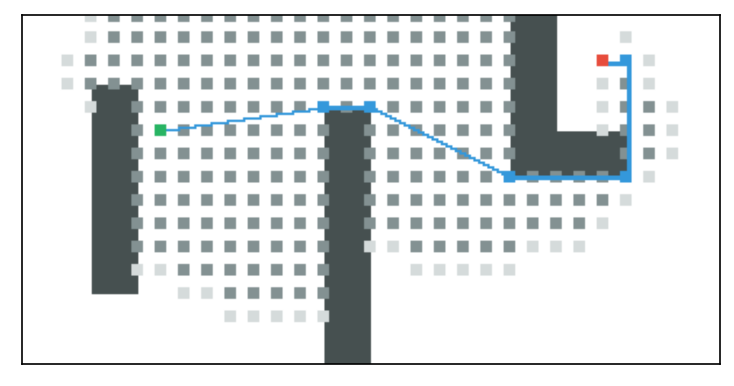

Path found! Length: 26.779271744364845. Nodes created: 816. Number of steps: 218. Correct: False


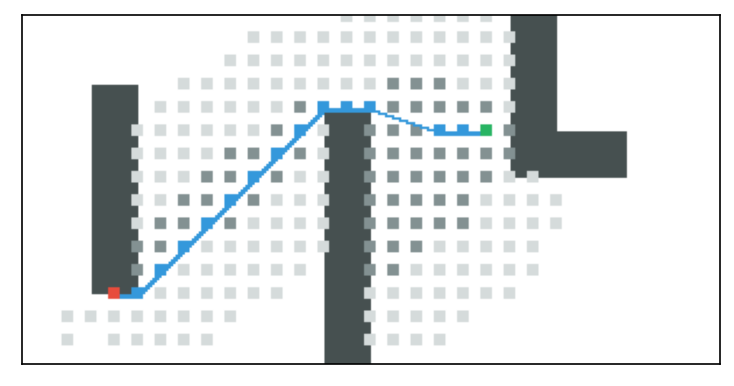

Path found! Length: 19.475986159153145. Nodes created: 1874. Number of steps: 72. Correct: False


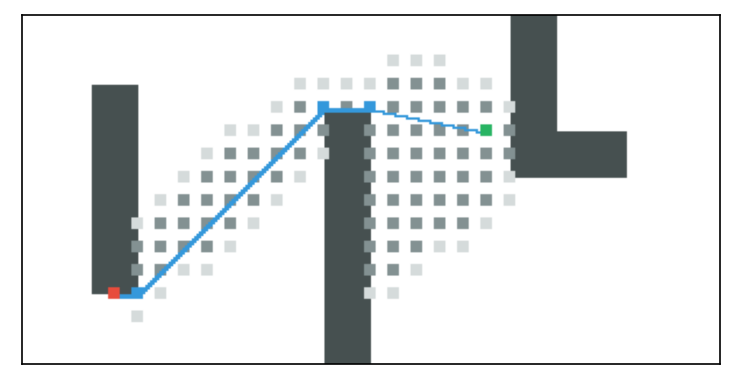

Path found! Length: 19.412728012577546. Nodes created: 283. Number of steps: 75. Correct: False


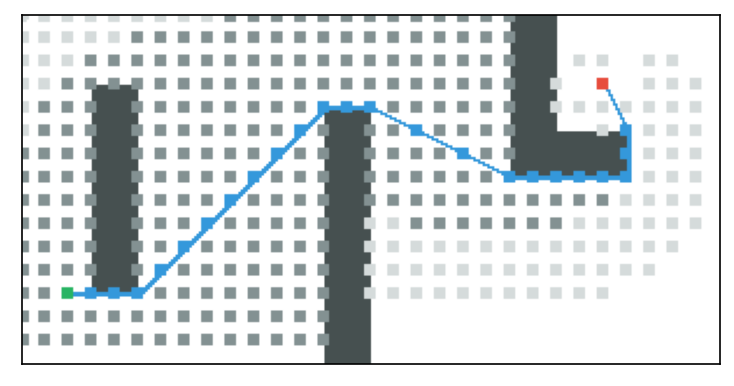

Path found! Length: 32.257980408983926. Nodes created: 6222. Number of steps: 268. Correct: False


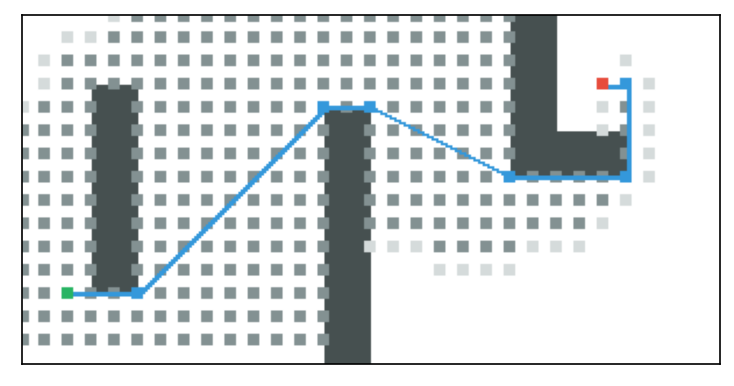

Path found! Length: 33.021912431484125. Nodes created: 1045. Number of steps: 284. Correct: False


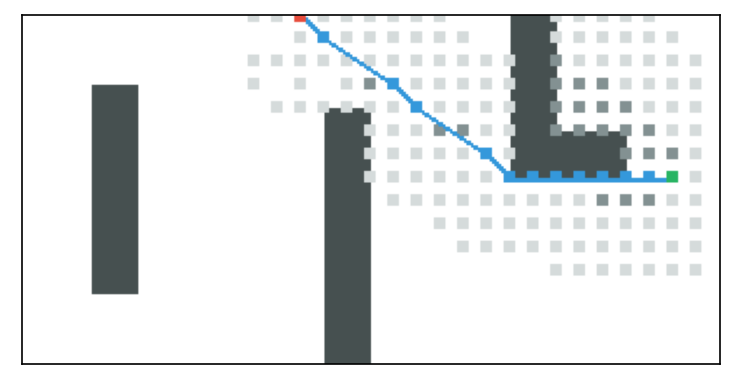

Path found! Length: 18.453743238047267. Nodes created: 744. Number of steps: 35. Correct: False


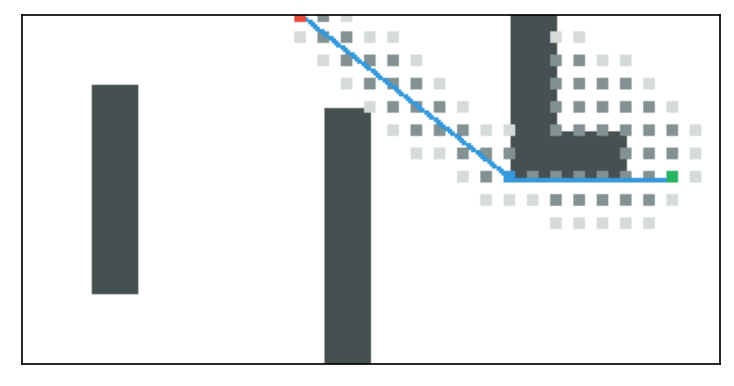

Path found! Length: 18.40175425099138. Nodes created: 194. Number of steps: 53. Correct: False


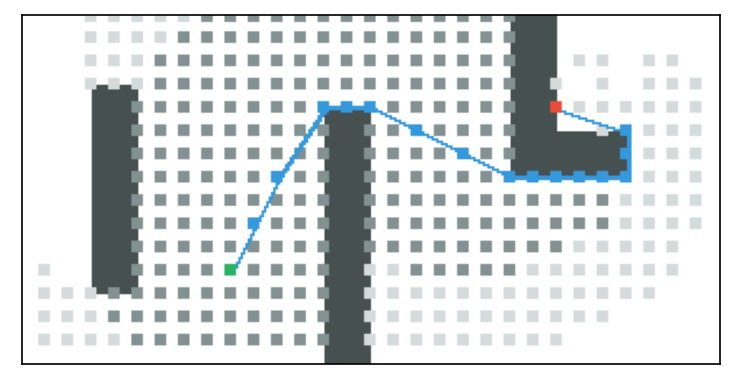

Path found! Length: 26.94816882313132. Nodes created: 5776. Number of steps: 235. Correct: False


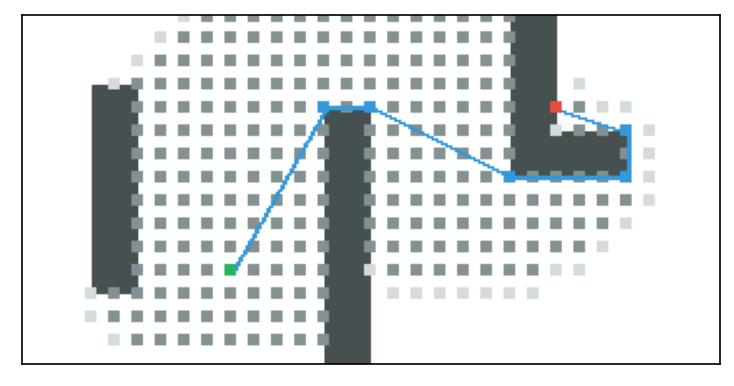

Path found! Length: 26.932739340966297. Nodes created: 905. Number of steps: 243. Correct: False


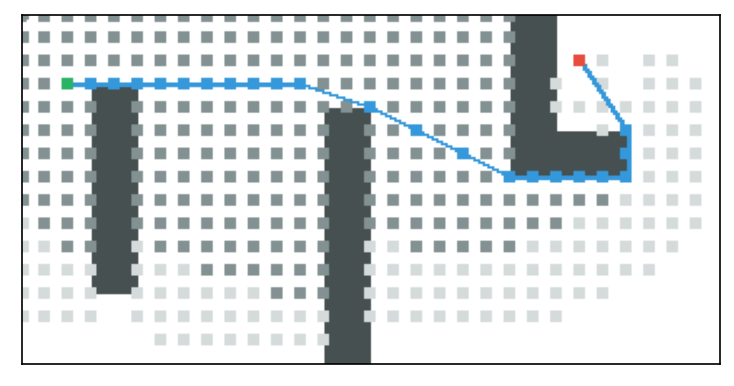

Path found! Length: 30.476032868131735. Nodes created: 5844. Number of steps: 246. Correct: False


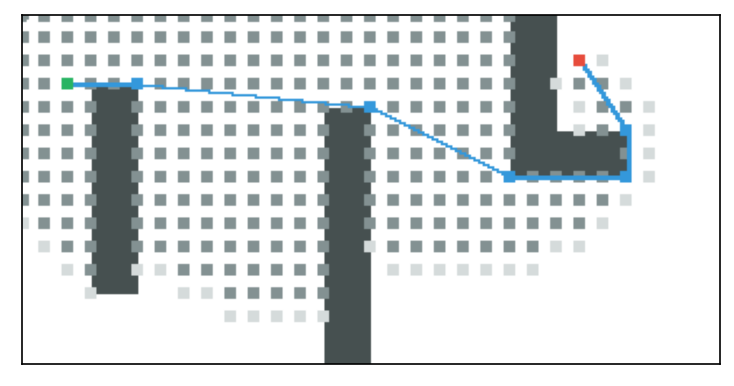

Path found! Length: 30.363630829084247. Nodes created: 958. Number of steps: 259. Correct: False


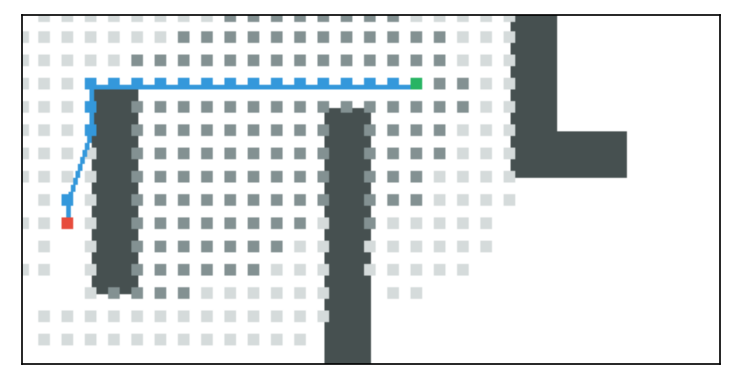

Path found! Length: 20.162277660168378. Nodes created: 3708. Number of steps: 146. Correct: False


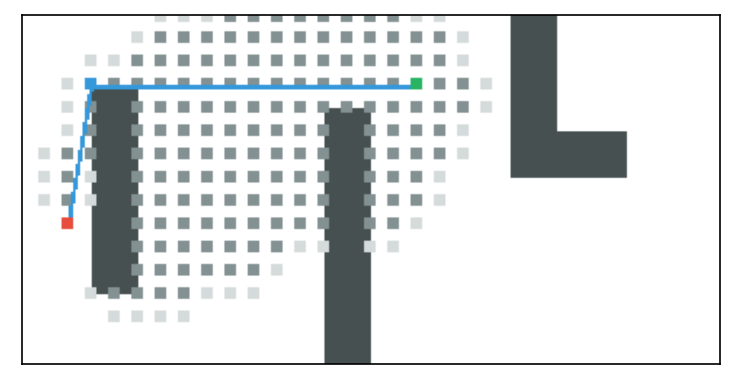

Path found! Length: 20.08276253029822. Nodes created: 572. Number of steps: 152. Correct: False


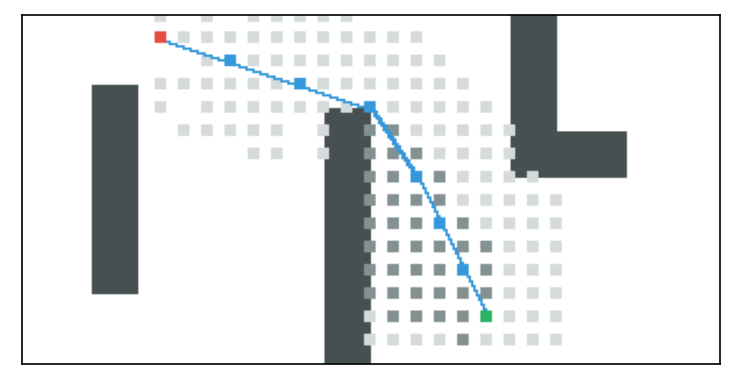

Path found! Length: 19.800588188468495. Nodes created: 1131. Number of steps: 46. Correct: False


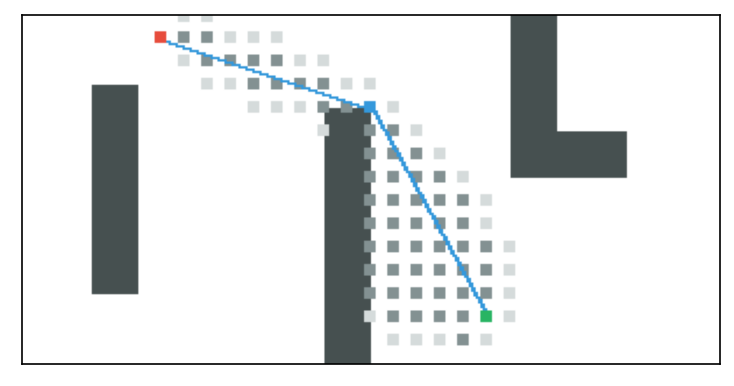

Path found! Length: 19.78246312149214. Nodes created: 214. Number of steps: 57. Correct: False


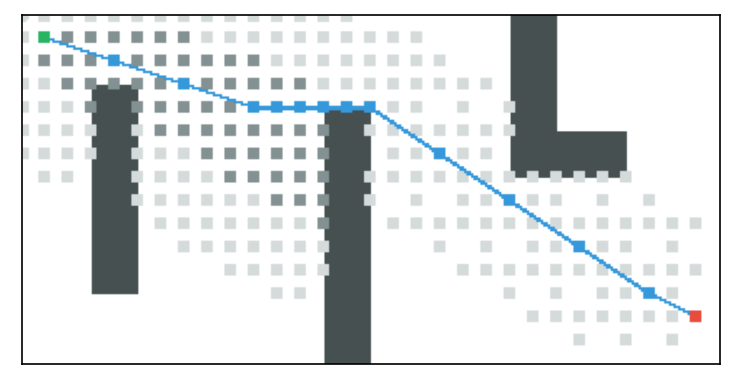

Path found! Length: 31.14510605986088. Nodes created: 1734. Number of steps: 68. Correct: False


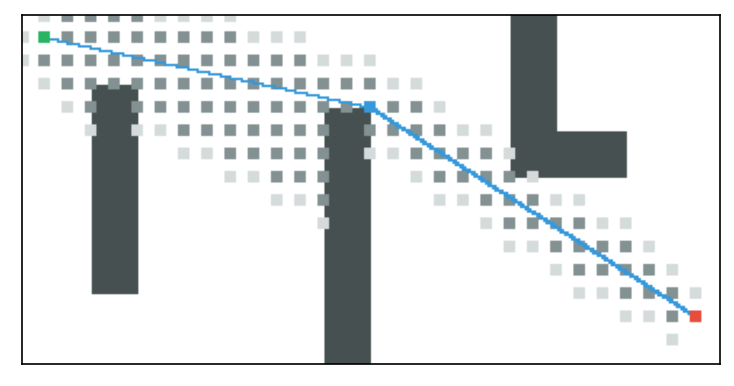

Path found! Length: 30.96113804036959. Nodes created: 387. Number of steps: 101. Correct: False


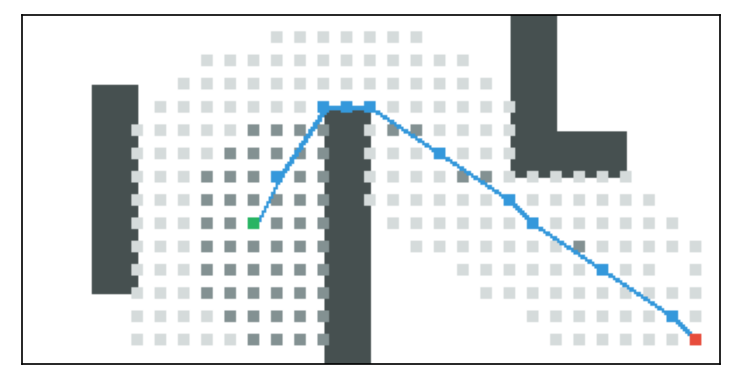

Path found! Length: 25.092251479565924. Nodes created: 1709. Number of steps: 68. Correct: False


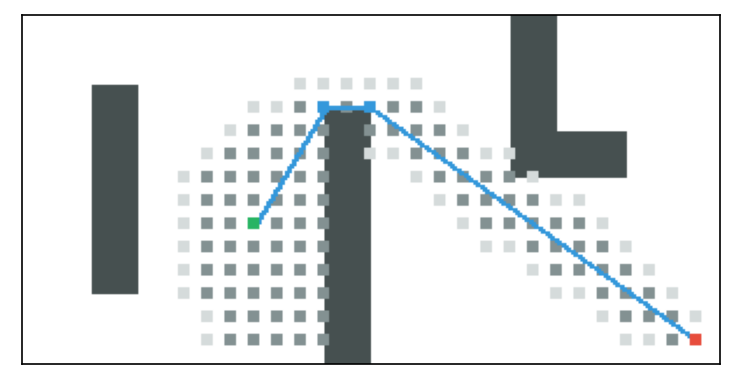

Path found! Length: 25.035602428930552. Nodes created: 366. Number of steps: 97. Correct: False


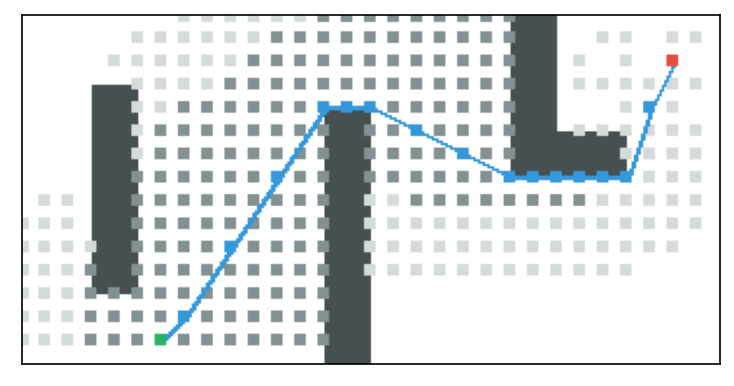

Path found! Length: 31.3374169589326. Nodes created: 4601. Number of steps: 191. Correct: False


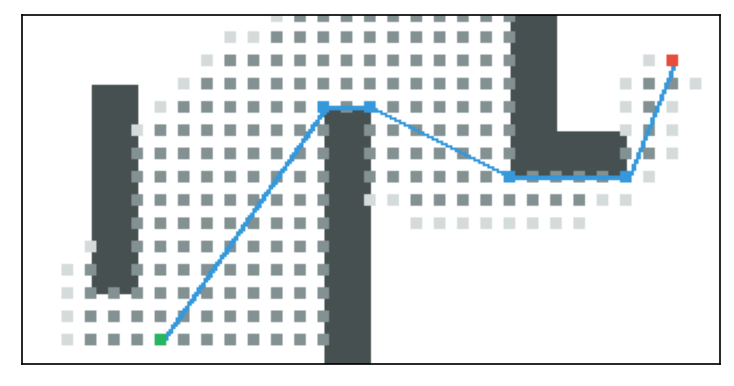

Path found! Length: 31.299924355367576. Nodes created: 741. Number of steps: 200. Correct: False


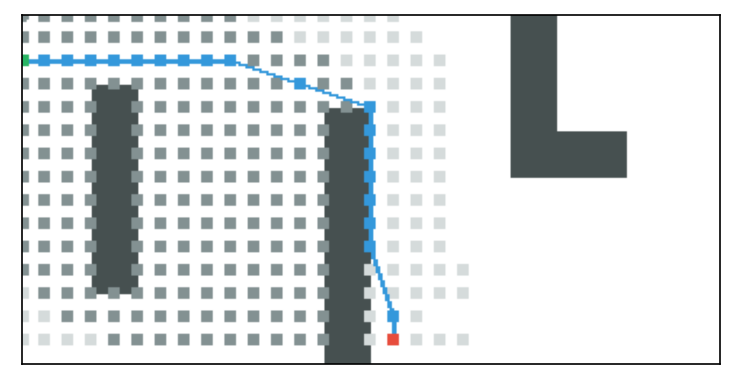

Path found! Length: 25.486832980505138. Nodes created: 4495. Number of steps: 200. Correct: False


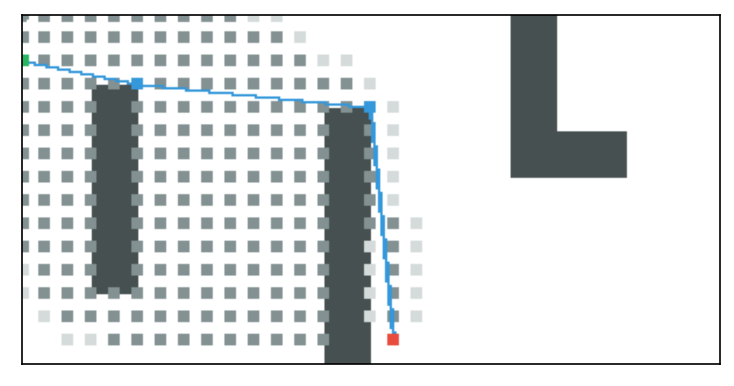

Path found! Length: 25.198770755834566. Nodes created: 735. Number of steps: 201. Correct: False


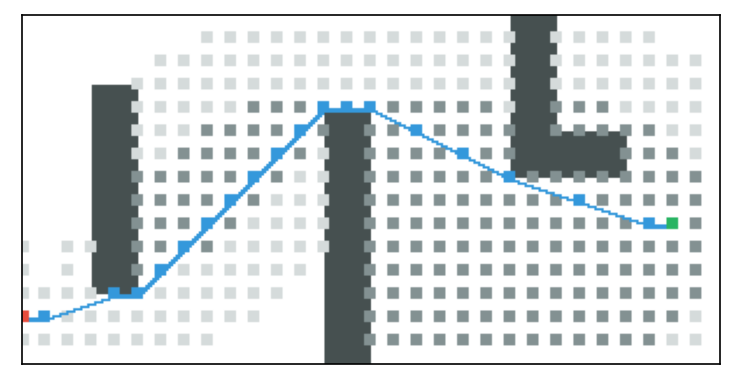

Path found! Length: 32.508745411989274. Nodes created: 4735. Number of steps: 193. Correct: False


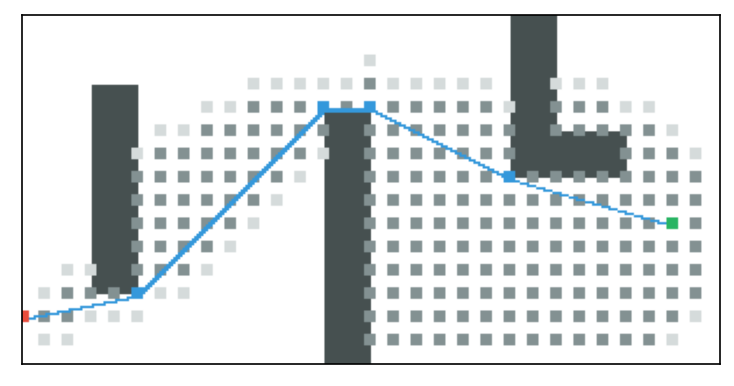

Path found! Length: 32.401041834357436. Nodes created: 743. Number of steps: 199. Correct: False


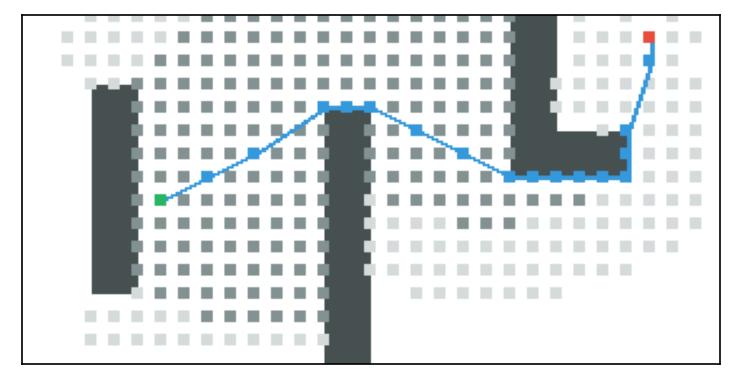

Path found! Length: 27.94816882313132. Nodes created: 4898. Number of steps: 198. Correct: False


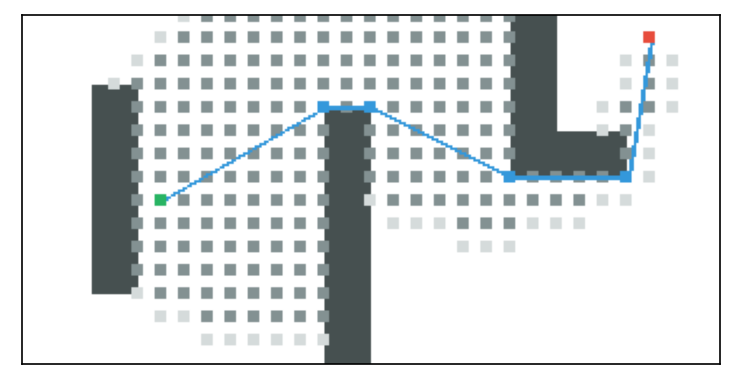

Path found! Length: 27.853224211096137. Nodes created: 753. Number of steps: 201. Correct: False


In [3]:
for i in range(20):
    simple_test(astar2k, i, uf.euclidian_distance, Open, Closed, 5)
    simple_test(thetastar, i, uf.euclidian_distance, Open, Closed)

In [484]:
"""def astar_reexpansion(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, open_and_closed_type = YourOpenAndClosed):
    start_node = Node(i = start_i, j = start_j)
    OPEN_AND_CLOSED = open_and_closed_type()
    steps = 0
    nodes_created = 0

    OPEN_AND_CLOSED.add_node(start_node)
    while not OPEN_AND_CLOSED.is_empty():
        current = OPEN_AND_CLOSED.get_best_node()
        steps += 1
        if (current.i == goal_i and current.j == goal_j):
            return (True, current, steps, nodes_created, OPEN_AND_CLOSED, OPEN_AND_CLOSED.expanded, OPEN_AND_CLOSED.reexpanded)
        for (neighbour_i, neighbour_j) in grid_map.get_neighbors(current.i, current.j):
            next_node = Node(i = neighbour_i, j = neighbour_j, g = current.g + compute_cost(current.i, current.j, neighbour_i, neighbour_j), h = heuristic_func(neighbour_i, neighbour_j, goal_i, goal_j), parent = current, k = nodes_created)
            nodes_created += 1
            OPEN_AND_CLOSED.add_node(next_node)

    return (False, None, steps, nodes_created, OPEN_AND_CLOSED, OPEN_AND_CLOSED.expanded, OPEN_AND_CLOSED.reexpanded)
"""

In [ ]:
for i in range(20):
    #res = simple_test(astar_reexpansion, i, euclidian_distance, YourOpenAndClosed)
    #print("Number of reexpansions:", res[4].number_of_reexpansions)
    pass